In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import boxcox1p
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
import warnings

In [3]:
df_train=pd.read_csv("train_fwYjLYX.csv")
print(df_train.shape)
print(df_train.isnull().sum())
print(df_train.head())
print(df_train['segment'].unique())
print(df_train['zone'].unique())
print(df_train['state'].unique())

(80402, 6)
application_date        0
segment                 0
branch_id           13504
state                   0
zone                13504
case_count              0
dtype: int64
  application_date  segment  branch_id        state  zone  case_count
0       2017-04-01        1        1.0  WEST BENGAL  EAST        40.0
1       2017-04-03        1        1.0  WEST BENGAL  EAST         5.0
2       2017-04-04        1        1.0  WEST BENGAL  EAST         4.0
3       2017-04-05        1        1.0  WEST BENGAL  EAST       113.0
4       2017-04-07        1        1.0  WEST BENGAL  EAST        76.0
[1 2]
['EAST' 'NORTH' 'SOUTH' 'WEST' 'CENTRAL' nan]
['WEST BENGAL' 'DELHI' 'KARNATAKA' 'TAMIL NADU' 'UTTAR PRADESH' 'PUNJAB'
 'TELANGANA' 'ANDHRA PRADESH' 'MAHARASHTRA' 'ORISSA' 'GUJARAT' 'ASSAM'
 'JHARKHAND' 'UTTARAKHAND' 'KERALA' 'CHHATTISGARH' 'BIHAR' 'TRIPURA'
 'MADHYA PRADESH' 'HARYANA']


In [4]:
df_train.info()
print(df_train.loc[df_train['segment']==1].count())
print(df_train.loc[df_train['segment']==2].count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null object
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.7+ MB
application_date    66898
segment             66898
branch_id           66898
state               66898
zone                66898
case_count          66898
dtype: int64
application_date    13504
segment             13504
branch_id               0
state               13504
zone                    0
case_count          13504
dtype: int64


In [5]:
df_seg_1=df_train.loc[df_train['segment']==1]
df_seg_2=df_train.loc[df_train['segment']==2]

In [6]:
#Stationarity Test
def test_stationarity(timeseries,cutoff = 0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    print(dfoutput)

In [7]:
#Calculation of Root Mean Square Error
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [8]:
#Calculating log transformation
def calculate_log(ts):
    for i in range(0,len(ts)):
        ts[i]=np.log(ts[i]+1)        
#        if(ts[i]==0):
#            ts[i]=np.log(1)
#        else:
#            ts[i]=np.log(ts[i])
    return ts

In [9]:
#Handling segment 2 date pivot table
df_seg_2.application_date=pd.to_datetime(df_seg_2.application_date,format="%Y-%m-%d")
print(df_seg_2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13504 entries, 66898 to 80401
Data columns (total 6 columns):
application_date    13504 non-null datetime64[ns]
segment             13504 non-null int64
branch_id           0 non-null float64
state               13504 non-null object
zone                0 non-null object
case_count          13504 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 738.5+ KB
None


C:\Users\HP\Miniconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
#state_seg1=df_seg_2[['application_date','branch_id','case_count']]

In [11]:
df_seg_2=df_seg_2.pivot_table('case_count',index='application_date',columns='state')

In [12]:
#Training and test segregation
df_seg_2_train=df_seg_2['2017-04-01':'2019-04-23']
df_seg_2_test=df_seg_2['2019-04-24':]

In [78]:
df_seg_2_test['ASSAM']

application_date
2019-04-24    7.329750
2019-04-25    7.257708
2019-04-26    7.123673
2019-04-27    6.979145
2019-04-28    6.456770
                ...   
2019-07-19    7.232733
2019-07-20    6.894670
2019-07-21    5.690359
2019-07-22    7.094235
2019-07-23    7.134891
Name: ASSAM, Length: 91, dtype: float64

C:\Users\HP\Miniconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


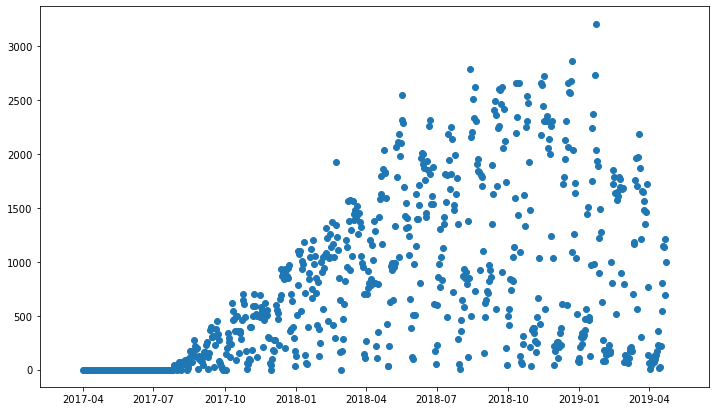

In [14]:
plt.figure(figsize=(12,7))
plt.scatter(df_seg_2_train.index,df_seg_2_train[['ASSAM']])
plt.show()

In [15]:
#Loop for multiple states selection
col_list=df_seg_2_test.columns.values
#for i in col_list:
    #print(i)
    #print(df_seg_2_test[i])

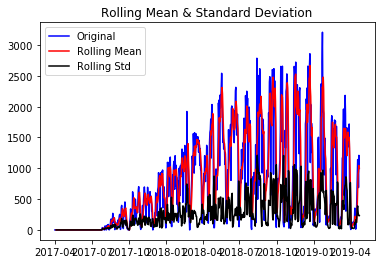

Results of Dickey-Fuller Test:
p-value = 0.0546. The series is likely non-stationary.
Test Statistic                  -2.826761
p-value                          0.054552
#Lags Used                      20.000000
Number of Observations Used    732.000000
Critical Value (1%)             -3.439315
Critical Value (5%)             -2.865497
Critical Value (10%)            -2.568877
dtype: float64


In [16]:
ts_seg2=df_seg_2_train['ASSAM']
test_stationarity(ts_seg2)

C:\Users\HP\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


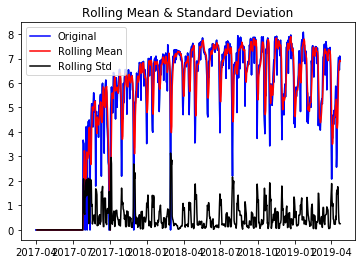

Results of Dickey-Fuller Test:
p-value = 0.1827. The series is likely non-stationary.
Test Statistic                  -2.267315
p-value                          0.182726
#Lags Used                      20.000000
Number of Observations Used    732.000000
Critical Value (1%)             -3.439315
Critical Value (5%)             -2.865497
Critical Value (10%)            -2.568877
dtype: float64


In [17]:
ts_log=calculate_log(ts_seg2)
plt.plot(ts_log)
test_stationarity(ts_log)

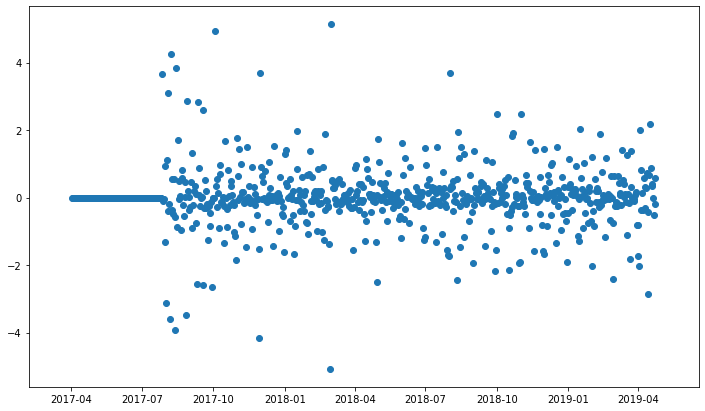

C:\Users\HP\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


In [18]:
ts_log_diff = ts_log - ts_log.shift(1)
plt.figure(figsize=(12,7))
plt.scatter(ts_log_diff.index,ts_log_diff)
plt.show()
ts_log_diff.to_csv('checku.csv')

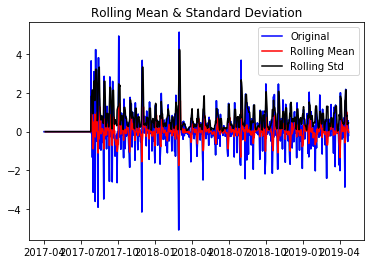

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.764375e+00
p-value                        7.416884e-17
#Lags Used                     1.900000e+01
Number of Observations Used    7.320000e+02
Critical Value (1%)           -3.439315e+00
Critical Value (5%)           -2.865497e+00
Critical Value (10%)          -2.568877e+00
dtype: float64


In [19]:
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [20]:
ts_log_test2=df_seg_2_test['ASSAM']

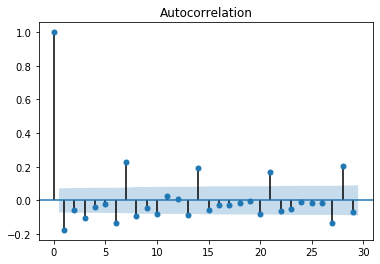

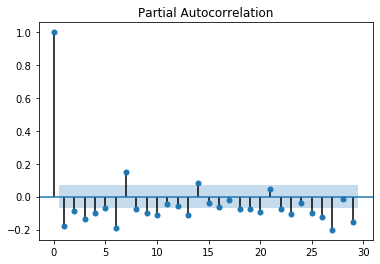

In [21]:
plot_acf(ts_log_diff)
plot_pacf(ts_log_diff,method='ols')
plt.show()

In [22]:
#running auto arima
model = auto_arima(ts_log,d=1,trace=True,error_action='ignore', suppress_warnings=True)
#result=model.fit(ts_log)
print(model.order,model.seasonal_order)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1892.162, BIC=1919.899, Fit time=2.040 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1976.078, BIC=1985.324, Fit time=0.233 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1954.521, BIC=1968.389, Fit time=0.198 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1948.514, BIC=1962.382, Fit time=0.264 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1974.157, BIC=1978.780, Fit time=0.050 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1890.877, BIC=1913.991, Fit time=1.265 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1937.380, BIC=1955.871, Fit time=0.384 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1889.465, BIC=1907.956, Fit time=0.672 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1890.808, BIC=1913.921, Fit time=0.873 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_o

C:\Users\HP\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\HP\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


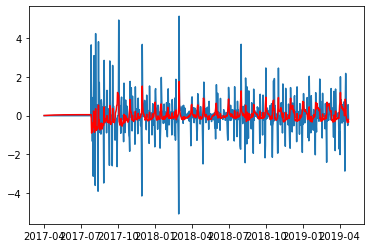

In [23]:
#ARIMA modelling
model_ARIMA = ARIMA(ts_log, order=(1,1,1))  
results_ARIMA = model_ARIMA.fit(disp=0)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [24]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.ASSAM   No. Observations:                  752
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -940.733
Method:                       css-mle   S.D. of innovations              0.845
Date:                Sun, 26 Jan 2020   AIC                           1889.465
Time:                        15:05:38   BIC                           1907.956
Sample:                    04-02-2017   HQIC                          1896.589
                         - 04-23-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0083      0.005      1.611      0.108      -0.002       0.018
ar.L1.D.ASSAM     0.6894      0.032     21.290      0.000       0.626       0.753
ma.L1.D.ASSAM    -0.9495      0.012    -

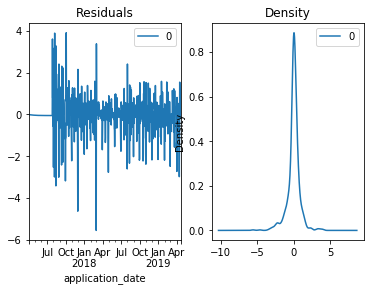

In [25]:
# Plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

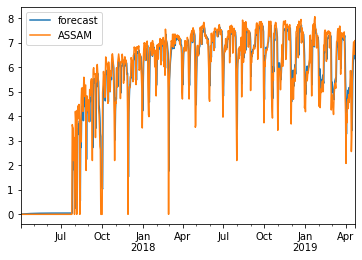

In [26]:
# Actual vs Fitted
results_ARIMA.plot_predict(dynamic=False)
plt.show()

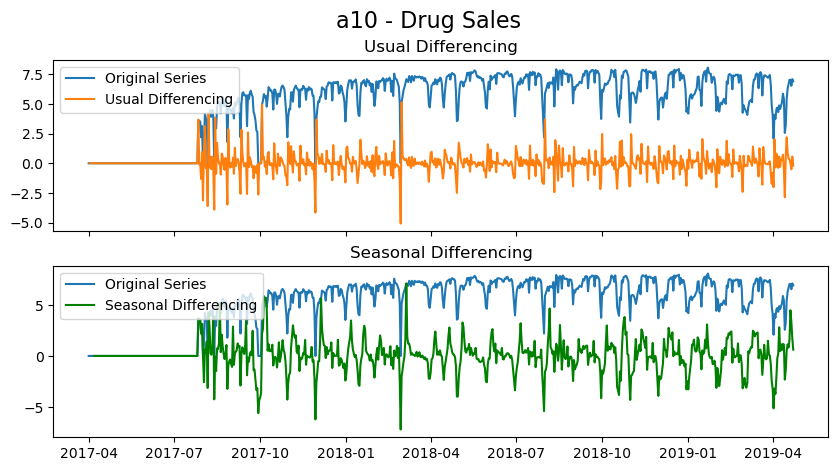

In [40]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(ts_seg2[:], label='Original Series')
axes[0].plot(ts_seg2[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(ts_seg2[:], label='Original Series')
axes[1].plot(ts_seg2[:].diff(6), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [72]:
#New way of auto-arima
smodel = auto_arima(ts_seg2, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         start_P=0, seasonal=True,
                         D=1,d=1,trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1889.465, BIC=1907.956, Fit time=0.663 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1976.078, BIC=1985.324, Fit time=0.258 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1954.521, BIC=1968.389, Fit time=0.181 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1948.514, BIC=1962.382, Fit time=0.271 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1974.157, BIC=1978.780, Fit time=0.045 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1890.808, BIC=1913.921, Fit time=0.975 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1890.877, BIC=1913.991, Fit time=1.325 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1937.380, BIC=1955.871, Fit time=0.332 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1950.614, BIC=1969.104, Fit time=0.179 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  753
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -940.733
Date:                Sun, 26 Jan 2020   AIC                           1889.465
Time:                        15:52:46   BIC                           1907.956
Sample:                             0   HQIC                          1896.589
                                - 753                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.002      1.320      0.187      -0.001       0.006
ar.L1          0.6894      0.024     28.717      0.000       0.642       0.736
ma.L1         -0.9495      0.012    -79.454      0.000      -0.973      -0.926
sigma2         0.7139      0.018     39.088      0.000       0.678       0.750
===================================================================================
Ljung-Box (Q):                      236.52   Jarque-Bera (JB):              1686.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
smodel.fit(ts_seg2)

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [76]:
future_forecast = smodel.predict(n_periods=90)

In [77]:
print(future_forecast)

[6.6583866  6.4897149  6.37598803 6.30014154 6.25041078 6.21868488
 6.199372   6.18861697 6.18376195 6.18297455 6.18499147 6.18894177
 6.19422499 6.20042715 6.20726286 6.21453535 6.22210897 6.2298902
 6.23781456 6.24583759 6.25392866 6.26206663 6.27023693 6.27842953
 6.2866375  6.29485606 6.30308192 6.31131283 6.3195472  6.32778397
 6.33602239 6.34426195 6.35250229 6.36074318 6.36898443 6.37722595
 6.38546764 6.39370945 6.40195135 6.4101933  6.41843529 6.42667732
 6.43491936 6.44316141 6.45140348 6.45964555 6.46788762 6.4761297
 6.48437178 6.49261386 6.50085594 6.50909802 6.5173401  6.52558219
 6.53382427 6.54206635 6.55030844 6.55855052 6.5667926  6.57503469
 6.58327677 6.59151885 6.59976094 6.60800302 6.6162451  6.62448719
 6.63272927 6.64097135 6.64921344 6.65745552 6.66569761 6.67393969
 6.68218177 6.69042386 6.69866594 6.70690802 6.71515011 6.72339219
 6.73163427 6.73987636 6.74811844 6.75636053 6.76460261 6.77284469
 6.78108678 6.78932886 6.79757094 6.80581303 6.81405511 6.822297

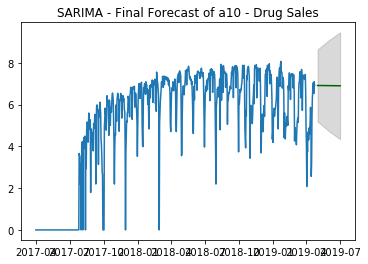

In [69]:
# Forecast
n_periods = 3
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(ts_seg2.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(ts_seg2)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

In [70]:
ts_seg2.index[-1]

Timestamp('2019-04-23 00:00:00')

In [71]:
index_of_fc

DatetimeIndex(['2019-05-01', '2019-06-01', '2019-07-01'], dtype='datetime64[ns]', freq='MS')

In [79]:
# double or triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [92]:
# create class
model = ExponentialSmoothing(ts_seg2,trend='add',seasonal_periods=7)

C:\Users\HP\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [93]:
# fit model
model_fit = model.fit(use_basinhopping=True)

In [94]:
# make prediction
yhat = model_fit.forecast(steps=91)

In [95]:
yhat

2019-04-24    6.938858
2019-04-25    6.948064
2019-04-26    6.957269
2019-04-27    6.966475
2019-04-28    6.975681
                ...   
2019-07-19    7.730546
2019-07-20    7.739751
2019-07-21    7.748957
2019-07-22    7.758163
2019-07-23    7.767368
Freq: D, Length: 91, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

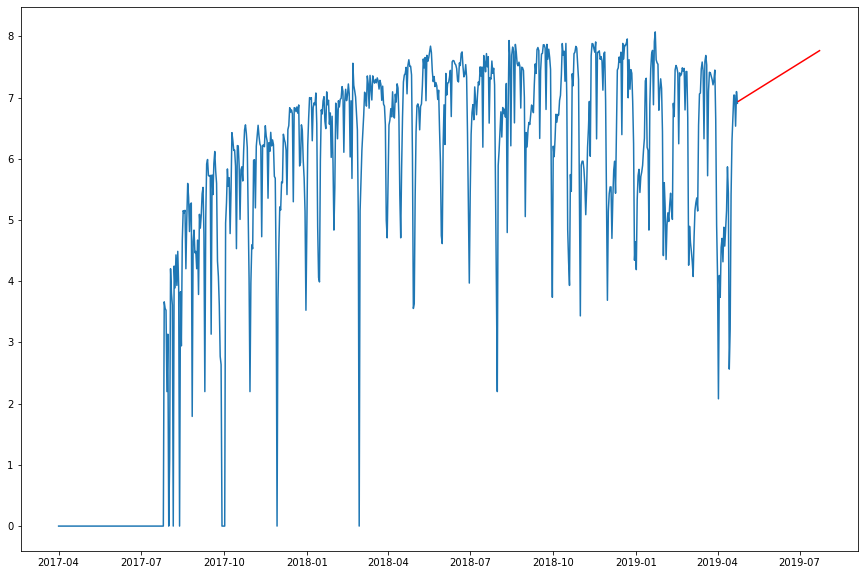

In [96]:
plt.figure(figsize=(15,10))
plt.plot(ts_seg2)
plt.plot(yhat, color='red')
plt.show

In [54]:
mod = sm.tsa.statespace.SARIMAX(ts_log,
                                order=model.order,
                                seasonal_order=(1,1,1,1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

C:\Users\HP\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3643      0.009     39.125      0.000       0.346       0.383
ma.L1         -1.0299      0.004   -270.826      0.000      -1.037      -1.022
ar.S.L1        0.3643      0.009     39.125      0.000       0.346       0.383
ma.S.L1       -1.0299      0.004   -270.826      0.000      -1.037      -1.022
sigma2         0.6564      0.019     34.088      0.000       0.619       0.694


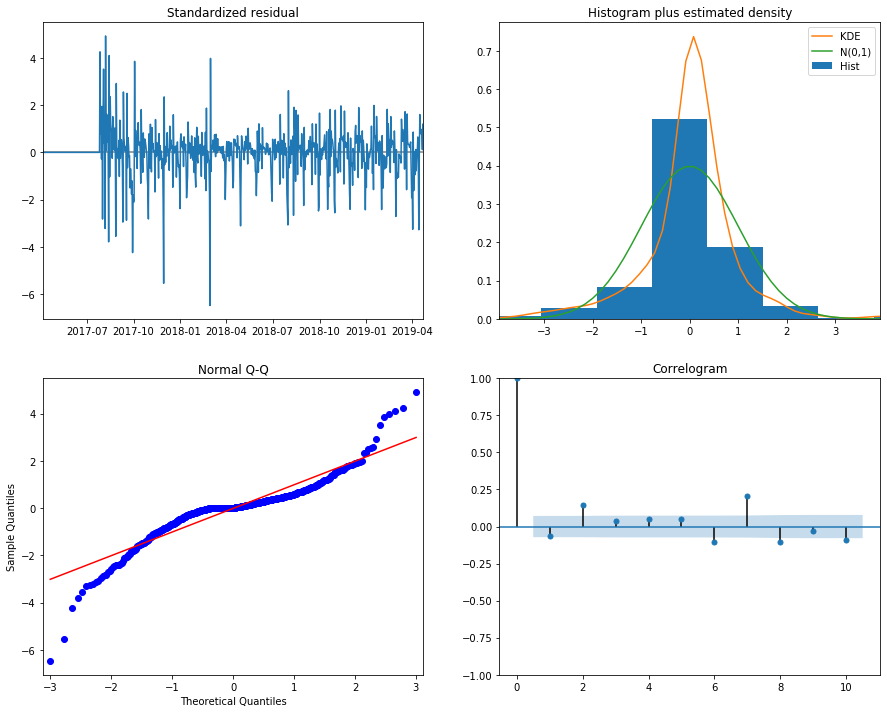

In [55]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [56]:
#pred = results.get_prediction(start=pd.to_datetime('2019-04-24'), dynamic=False)
#pred_ci = pred.conf_int()

In [57]:
pred_uc1=results.get_prediction(start=pd.to_datetime('2019-04-24'),end=pd.to_datetime('2019-07-23'))

In [58]:
pred_uc1.prediction_results

In [59]:
ts_log.tail()

application_date
2019-04-19    7.040536
2019-04-20    7.039660
2019-04-21    6.533789
2019-04-22    7.099202
2019-04-23    6.906755
Name: ASSAM, dtype: float64

In [60]:
ts_log_tes=calculate_log(df_seg_2_test['ASSAM'])

C:\Users\HP\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
ts_log_tes

application_date
2019-04-24    7.329750
2019-04-25    7.257708
2019-04-26    7.123673
2019-04-27    6.979145
2019-04-28    6.456770
                ...   
2019-07-19    7.232733
2019-07-20    6.894670
2019-07-21    5.690359
2019-07-22    7.094235
2019-07-23    7.134891
Name: ASSAM, Length: 91, dtype: float64

In [62]:
pred_uc = results.get_forecast(steps=91)

In [63]:
results.fittedvalues()

TypeError: 'Series' object is not callable

In [64]:
pred_uc.predicted_mean

2019-04-24    6.401074
2019-04-25    6.055260
2019-04-26    5.867508
2019-04-27    5.773709
2019-04-28    5.727390
                ...   
2019-07-19    5.110830
2019-07-20    5.103668
2019-07-21    5.096506
2019-07-22    5.089344
2019-07-23    5.082182
Freq: D, Length: 91, dtype: float64

In [65]:
sar_val=np.exp(pred_uc.predicted_mean)

In [66]:
sar_val_ori=np.exp(df_seg_2_test['ASSAM'])

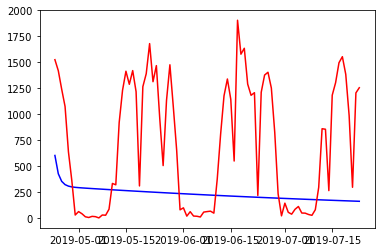

In [67]:
plt.plot(sar_val, color='blue',label='predict')
plt.plot(sar_val_ori, color='red', label='original')
plt.show(block=False)

In [363]:
ts_log_test2['pred']=

SyntaxError: invalid syntax (<ipython-input-363-b514bb808dad>, line 1)

In [284]:
model_arima = sm.tsa.ARIMA(ts_log, order=model.order)
model_arima2 = model_arima.fit()
results_ARIMA2=model_arima2.predict(typ='levels')
concatenated = pd.concat([ts_log, results_ARIMA], axis=1, keys=['original', 'predicted'])
concatenated.head(10)

C:\Users\HP\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\HP\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


TypeError: cannot concatenate object of type '<class 'statsmodels.tsa.arima_model.ARIMAResultsWrapper'>'; only Series and DataFrame objs are valid

C:\Users\HP\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\HP\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: nan')

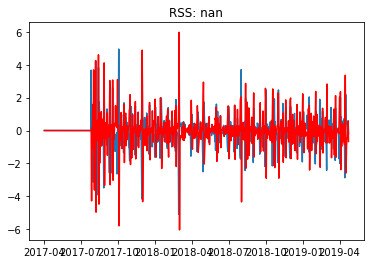

In [312]:
#ARIMA modelling
model_ARIMA = ARIMA(ts_log_diff, order=(1,1,1))  
results_ARIMA = model_ARIMA.fit(disp=0)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [313]:
pred_df=ts_log_test2.index
pred_df

DatetimeIndex(['2019-04-24', '2019-04-25', '2019-04-26', '2019-04-27',
               '2019-04-28', '2019-04-29', '2019-04-30', '2019-05-01',
               '2019-05-02', '2019-05-03', '2019-05-04', '2019-05-05',
               '2019-05-06', '2019-05-07', '2019-05-08', '2019-05-09',
               '2019-05-10', '2019-05-11', '2019-05-12', '2019-05-13',
               '2019-05-14', '2019-05-15', '2019-05-16', '2019-05-17',
               '2019-05-18', '2019-05-19', '2019-05-20', '2019-05-21',
               '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
               '2019-05-26', '2019-05-27', '2019-05-28', '2019-05-29',
               '2019-05-30', '2019-05-31', '2019-06-01', '2019-06-02',
               '2019-06-03', '2019-06-04', '2019-06-05', '2019-06-06',
               '2019-06-07', '2019-06-08', '2019-06-09', '2019-06-10',
               '2019-06-11', '2019-06-12', '2019-06-13', '2019-06-14',
               '2019-06-15', '2019-06-16', '2019-06-17', '2019-06-18',
      

In [314]:
w_diff=results_ARIMA.predict(start=pd.to_datetime('2019-04-24'),end=pd.to_datetime('2019-07-23'))

In [315]:
w_diff

2019-04-24    0.220227
2019-04-25   -0.038474
2019-04-26    0.006669
2019-04-27   -0.001208
2019-04-28    0.000166
                ...   
2019-07-19   -0.000038
2019-07-20   -0.000038
2019-07-21   -0.000038
2019-07-22   -0.000038
2019-07-23   -0.000038
Freq: D, Length: 91, dtype: float64

In [242]:
pred_df['pred']=results_ARIMA.get_forecast(steps=500)

AttributeError: 'ARIMAResults' object has no attribute 'get_forecast'

In [139]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.tail())
predictions_ARIMA_diff.to_csv('log_comp.csv')

application_date
2019-04-19   -0.283168
2019-04-20   -0.359545
2019-04-21   -0.338607
2019-04-22   -0.185963
2019-04-23   -0.322646
dtype: float64


C:\Users\HP\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [123]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.tail())
print(ts_log.tail())
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
print(predictions_ARIMA_log)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.tail())
ts_log.to_csv('log_compare.csv')
predictions_ARIMA_log.to_csv('log_compare1.csv')

application_date
2019-04-19    8.662726
2019-04-20    8.303181
2019-04-21    7.964574
2019-04-22    7.778612
2019-04-23    7.455965
dtype: float64
application_date
2019-04-19    7.039660
2019-04-20    7.038784
2019-04-21    6.532334
2019-04-22    7.098376
2019-04-23    6.905753
Name: ASSAM, dtype: float64
application_date
2017-04-01    0.0
2017-04-02    0.0
2017-04-03    0.0
2017-04-04    0.0
2017-04-05    0.0
             ... 
2019-04-19    0.0
2019-04-20    0.0
2019-04-21    0.0
2019-04-22    0.0
2019-04-23    0.0
Length: 753, dtype: float64
application_date
2019-04-19    8.662726
2019-04-20    8.303181
2019-04-21    7.964574
2019-04-22    7.778612
2019-04-23    7.455965
dtype: float64


C:\Users\HP\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
C:\Users\HP\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':


In [120]:
print(ts_log.iloc[700])
print(predictions_ARIMA_log.iloc[700])

4.624972813284271
0.7404423033575914


Text(0.5, 1.0, 'RMSE: nan')

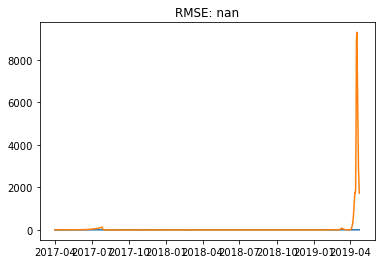

In [117]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(figsize=(60,30))
plt.plot(df_seg_2_train['ASSAM'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df_seg_2['ASSAM'])**2)/len(df_seg_2['ASSAM'])))

In [118]:
print(predictions_ARIMA)

application_date
2017-04-01       1.000000
2017-04-02       1.008279
2017-04-03       1.017909
2017-04-04       1.028917
2017-04-05       1.041331
                 ...     
2019-04-19    5783.277251
2019-04-20    4036.692709
2019-04-21    2877.204637
2019-04-22    2388.955793
2019-04-23    1730.153514
Length: 753, dtype: float64
